In [1]:
# read BHMF file ../M0r8_f*linBHMFz

In [2]:
from PYmodule import *
from PYmodule.models_logd import *
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

In [3]:
print(t_from_z(30)/Myr,t_from_z(17)/Myr,t_from_z(10)/Myr, t_from_z(6)/Myr, t_from_z(5)/Myr, t_from_z(4)/Myr)
print(T[['z_col']][np.argmax(T['Mstar0'])])
print(T.info)
print('collapse halo mass: {:.1e}, {:.1e}'.format(np.max(T['Mh_col']),np.min(T['Mh_col'])))
print('collapse stellar mass: {:.1e}, {:.1e}'.format(np.max(T['Mstar0']),np.min(T['Mstar0'])))
T['Tv'] = Tv(T['Mh_col'],T['z_col'])
print('collapse halo Tvir: {:.1e}, {:.1e}'.format(np.max(T['Tv']),np.min(T['Tv'])))


97.95418409892392 221.38937521765934 463.42184782836443 912.8900473748333 1150.3729383987484 1512.2044989707888
z_col
-----
33.42
<Table length=10000>
  name   dtype 
------- -------
   tree   int64
  i_bsm   int64
iso_col   int64
  z_col float64
 Mh_col float64
 ng_col float64
 Tg_col float64
Mg_intg float64
 MJ_col float64
  J_col float64
  f_col float64
 ng_loi float64
 Tg_loi float64
 MJ_loi float64
  f_loi float64
 Tg_1e4 float64
  f_1e4 float64
 Tg_max float64
   Mdot float64
 Mstar0 float64
  t_col float64

collapse halo mass: 2.8e+07, 2.2e+05
collapse stellar mass: 1.8e+05, 2.2e+02
collapse halo Tvir: 2.3e+04, 1.1e+03


In [4]:
linestyles = {0.1:'-',0.01:'--'}
legendprex = {0.1:'',0.01:'_'}

In [5]:
zmax = 11
zs = np.arange(6,zmax,1)
# cm = plt.get_cmap('tab20b')
# NUM_COLORS = len(zs)

# lines[0].set_color(cm(i/NUM_COLORS))
#     lines[0].set_linestyle(LINE_STYLES[0%NUM_STYLES])

## BHMF seed+growth

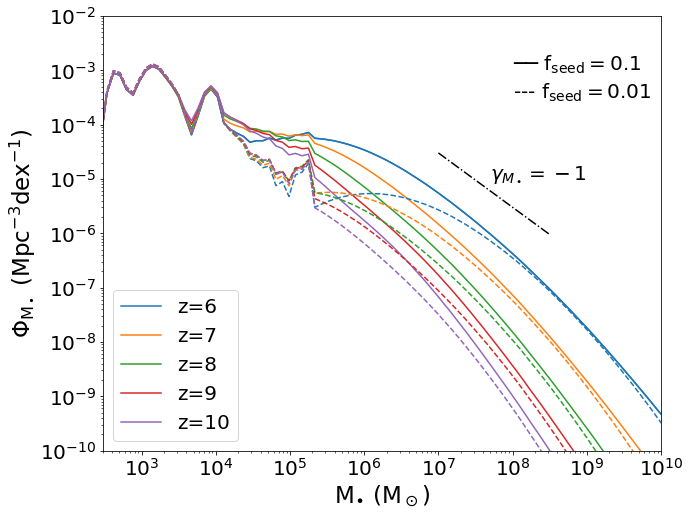

In [7]:
%matplotlib inline

zs = np.arange(6,zmax,1)
# xs of models
Mx = M_BH[::int(N_mf/100)] # ~100 points
dlog10Mx = np.log10(Mx[1]/Mx[0])
abin = np.append(np.log10(Mx)-dlog10Mx/2., np.log10(Mx[-1])+dlog10Mx/2.)

figm, axm = plt.subplots(num='MF',figsize=(10, 8))
axm.plot(np.logspace(7,8.5), 3e-5/(np.logspace(6,7.5)/1e6),'-.',
        color='k', label=r'_$\gamma=-1$')
axm.text(5e7,1e-5,r'${\gamma_{M_\bullet}=-1}$',color='k',fontsize=fslegend)
# axm.text(5e6,1e-3,r'${\alpha_{M_{BH}}=-1}$',fontsize=fslegend)

for f_seed in [0.1, 0.01]:
    f_seedlabel = 'f%d'%abs(int(np.log10(f_seed)))
    # readprex = '../4p/M0r8_' + f_seedlabel # on sk1
    readprex = '../M0r8_' + f_seedlabel # local
    fname = readprex + '.h5'
    prex = readprex
    # fname = '../4p/3n2f_logd_4pr8_f2.h5'
    reader = emcee.backends.HDFBackend(fname)
#     ndim = len(labels)

    tau = reader.get_autocorr_time(tol=1)
    tau = np.max(tau); #print('max tau:',tau)
    Nburnin = int(3*tau)
    Nthin = int(tau/2)
    T_stay = T[:-int(f_seed*len(T))]

    for z in zs:    
        #--- output 3 curves: best, med, std
        T_ = ascii.read(prex+'linBHMFz{:d}'.format(z), guess=False, delimiter=' ')
        Mx, y_best, med, spread = T_['Mx'], T_['y_best'], T_['med'], T_['spread']
        # add seed M_BHs using T_stay
        hist_mf, bin_edges = np.histogram(np.log10(T_stay['Mstar0']),bins=abin,density=False)
        y_tot = y_best + hist_mf*n_base*f_bsm/len(T)/dlog10Mx
        # add seed M_BHs using T * (1-f_seed)
        hist_mf, bin_edges = np.histogram(np.log10(T['Mstar0']),bins=abin,density=False)
        y_tot = y_best + hist_mf*(1-f_seed)*n_base*f_bsm/len(T)/dlog10Mx

        if z==6 and f_seed==0.1:
            line1, = axm.plot(Mx, y_tot,ls=linestyles[f_seed],
                             color='C%d'%(z%zs[0]), label='_')
        if z==6 and f_seed==0.01:
            line2, = axm.plot(Mx, y_tot,ls=linestyles[f_seed],
                             color='C%d'%(z%zs[0]), label='_')
        else:
            axm.plot(Mx, y_tot,ls=linestyles[f_seed],
                       color='C%d'%(z%zs[0]), label=legendprex[f_seed]+'z=%d'%z)

        T_tot = Table(
            [Mx, y_best, y_tot, med, spread],
            names=('Mx','y_growth','y_tot','med','spread')
        )
        MFname = prex+'totBHMFz{:d}'.format(z)
        ascii.write(T_tot,
                    MFname,
                    formats={'Mx':'4.2e','y_growth':'4.2e','y_tot':'4.2e','med':'4.2e','spread':'4.2e'},
                    overwrite=True)
# # Create a legend -- not working
# first_legend = ax.legend([line1,line2], [r"$\mathrm{f_{seed}=0.1}$",r"$\mathrm{f_{seed}=0.01}$"], 
#            loc='lower left',fontsize=fslegend)
# # Add the legend manually to the Axes.
# axm.add_artist(first_legend)

axm.text(1e8,1e-3,'\u2500'*2+' '+r"$\mathrm{f_{seed}=0.1}$",fontsize=fslegend)
axm.text(1e8,3e-4,'--- '+r"$\mathrm{f_{seed}=0.01}$",fontsize=fslegend)
axm.legend(loc='lower left',fontsize=fslegend)


axm.set_xlim(3e2,1e10); axm.set_xscale('log')
axm.set_ylim(1e-10,1e-2); 
axm.set_yscale('log') # set before tickers

locmajy = LogLocator(base=10,numticks=100)
locminy = LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100)
axm.yaxis.set_major_locator(locmajy)
axm.yaxis.set_minor_locator(locminy)
axm.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axm.tick_params(labelsize=fstick)

axm.set_xlabel(r'$\mathrm{M_{\bullet}~(M_\odot)}$',fontsize=fslabel)
axm.set_ylabel(r'$\mathrm{\Phi_{M_\bullet}~(Mpc^{-3}dex^{-1})}$',fontsize=fslabel)
figm.savefig(figpre+'MF.pdf',dpi=600,bbox_inches='tight')

In [7]:
prex+'linBHMFz{:d}'.format(z)


'../M0r8_f2linBHMFz10'

In [8]:
# Ni2022 line data:

x_5 = np.array([6.004247726894137, 6.353173545413434, 6.697802335885871, 6.986523069849572, 7.220508537957151, 7.58925781440437, 7.9963383937739385, 8.37412117948682, 8.65991268340132, 8.994971007763628, 9.287304870775364, 9.58291128662688, 9.852491088370328])
y_5 = np.array([1793.701869438519, 1405.4958413611396, 1056.8765164079111, 893.7248632005056, 734.7805802722235, 565.4430846589914, 427.49664462995986, 325.5964372752263, 267.6248829495159, 219.21919168222584, 155.589874890373, 108.67841817117636, 82.90568664930193])
x_56 = np.array([5.990282729064624, 6.217578895920598, 6.441260560437378, 6.590575761932837, 6.801415780790872, 7.019092043054876, 7.171679797390116, 7.351026130022934, 7.574707794539714, 7.770312521243099, 7.960351298865648, 8.203076391930157, 8.360547569638566, 8.503956245844936, 8.811865977219572, 8.962353969367644, 9.129688124203751, 9.390528300990269, 9.536474819264583, 9.718604813083402, 9.910986425428849])
y_56 = np.array([4536.4779684955865, 3568.6706259692123, 3037.4957236193177, 2679.2119465091328, 2204.3527839403423, 1823.7174908699938, 1638.7421617724547, 1491.1075142291738, 1203.8195932440808, 1078.2670029551998, 929.011049406025, 762.4780164944057, 670.3946906280294, 593.3584095142435, 469.53406728896437, 428.9705472045848, 365.7497737578557, 268.91109745886337, 223.51883187105426, 185.92582299148205, 148.74462572550706])

x_68 = np.array([6.010791459282537, 6.208984839826874, 6.432714569534333, 6.704541075619318, 6.9815435160950425, 7.212353935035363, 7.426562637114541, 7.649072884269872, 7.856055328252982, 8.107910060964516, 8.29848716872269, 8.490918219549982, 8.66958065318397])
y_68 = np.array([122.78834568377343, 83.74560148788649, 55.21181950490279, 32.95830781311721, 19.1093177367493, 10.61042528841991, 6.359563346365861, 3.6203694283347962, 2.218215969507189, 1.1394557043671962, 0.6697363215810173, 0.37232761930018216, 0.2319157216683597])

x_8 = np.array([6.000147079483483])
y_8 = np.array([21.752813967509663])


# Treister+13 CXB upper bounds:
x_T13 = np.array([6.503710976043349, 7.495849296126483, 8.505372109033276])
y_T13 = np.array([967.7108010103492, 722.0653224691073, 966.2840572673749])
y_T13 = np.array([851, 666, 674])


max tau: 319.7886281393154
len of samples: 4041
len of extracted samples: 404100
best paras: [21.08433424 -2.9978112   0.86296566  0.1358891 ] -4.138745827174311
max tau: 249.58268579763228
len of samples: 4252
len of extracted samples: 425200
best paras: [18.7555167  -1.2574505   0.87372563  0.20389703] -3.1054538991409824


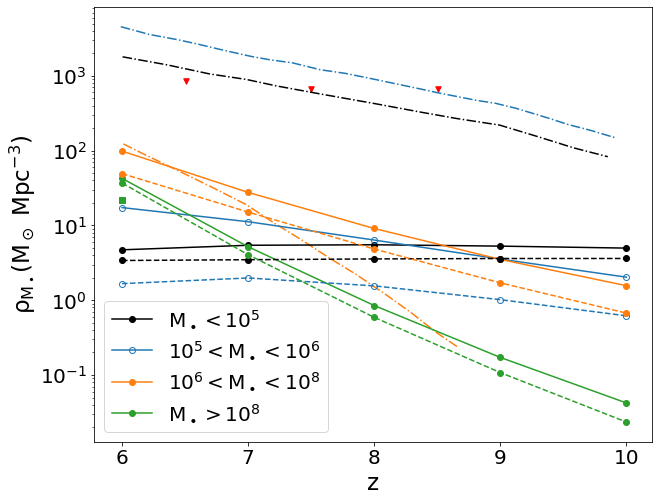

In [9]:
# M range: <5, 5-6, 6-8, >8

%matplotlib inline
corr = 'U'
zmax = 11
M_up  = 1e7
L_up  = -26
# L_ups = [-23,-24,-25,-26,-27] # 可用集合
ndraw = 3
labels = [r'$\mathrm{t_{life}}$', r'$\log \delta$', r'$\lambda_0$', r'$\alpha$']

fig, ax = plt.subplots(num='rhoM',figsize=(10, 8))

# Ni 2022 & Treister 2013
ax.plot(x_5,y_5,linestyle='-.',label='_',c='k')
ax.plot(x_56,y_56,linestyle='-.',label='_',c='C0')
p1, = ax.plot(x_68,y_68,linestyle='-.',c='C1',label='_Ni+ 22')
p2 = ax.scatter(x_8,y_8,marker='s',c='C2',label='_Ni+ 22')
# # no use
# from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
# l = ax.legend([(p1, p2)], ['Two keys'], numpoints=1,
#               handler_map={tuple: HandlerTuple(ndivide=None)})
ax.scatter(x_T13,y_T13,marker='v',s=30,c='red',label='_Treister+ 13')

for f_seed in [0.1, 0.01]:
    f_seedlabel = 'f%d'%abs(int(np.log10(f_seed)))
    # readprex = '../4p/M0r8_' + f_seedlabel # on sk1
    readprex = '../M0r8_' + f_seedlabel # local
    fname = readprex + '.h5'
    prex = readprex
    # fname = '../4p/3n2f_logd_4pr8_f2.h5'
    reader = emcee.backends.HDFBackend(fname)
    ndim = len(labels)

    tau = reader.get_autocorr_time(tol=1)
    tau = np.max(tau); print('max tau:',tau)
    Nburnin = int(3*tau)
    Nthin = int(tau/2)

    # Nburnin = 0
    Nthin = 1
    samples = reader.get_chain(discard=Nburnin)
    probs = reader.get_log_prob(discard=Nburnin)
    print('len of samples:', len(samples))

    samples = reader.get_chain(discard=Nburnin, thin=Nthin, flat=True)
    probs = reader.get_log_prob(discard=Nburnin, thin=Nthin, flat=True)
    print('len of extracted samples:', len(samples))
    theta_max = samples[np.argmax(probs)]
    print('best paras:',theta_max,np.max(probs))
    T_stay = T[:-int(f_seed*len(T))]
    
    
    z = 6
    zs = np.arange(z,zmax,1)

    rhoM_min = []; rhoM_max = []
    rhoM = {'<1e5':[],'1e5<M<1e6':[],'<1e5_int':[],'1e6<M<1e8':[],'>1e8':[]}
    # xs of models
    Mx = M_BH[::int(N_mf/100)] # ~100 points

    dlog10Mx = np.log10(Mx[1]/Mx[0])
    abin = np.append(np.log10(Mx)-dlog10Mx/2., np.log10(Mx[-1])+dlog10Mx/2.)
#     print(abin)
    for z in zs:    
        #--- output 3 curves: best, med, std
        T_ = ascii.read(prex+'linBHMFz{:d}'.format(z), guess=False, delimiter=' ')
        Mx, y_best, med, spread = T_['Mx'], T_['y_best'], T_['med'], T_['spread']
        # add seed M_BHs 
        hist_mf, bin_edges = np.histogram(np.log10(T_stay['Mstar0']),bins=abin,density=False)
#         print(hist_mf)
#         y_seed = hist_mf*n_base*f_bsm/len(T)/dlog10Mx,

#         axm.plot(Mx, y_best+hist_mf*n_base*f_bsm/len(T)/dlog10Mx,
#                  color='C%d'%(z%10), label='z=%d'%z)

        y_tot = y_best+hist_mf*n_base*f_bsm/len(T)/dlog10Mx
        #--- mass integration above M_up
        dn_best = y_best*dlog10Mx
        
        index = np.where(Mx<1e5)
        rhoM['<1e5'].append(np.sum(dn_best[index]*Mx[index]) + n_base*f_bsm*np.sum(T_stay['Mstar0'])/len(T) )
#         rhoM['<1e5_int'].append(np.sum(y_tot[index]*Mx[index]*dlog10Mx))
        index = np.logical_and(Mx>1e5,Mx<1e6)
        rhoM['1e5<M<1e6'].append(np.sum(dn_best[index]*Mx[index]) )
        index = np.logical_and(Mx>1e6,Mx<1e8)
        rhoM['1e6<M<1e8'].append(np.sum(dn_best[index]*Mx[index]) )
        index = np.where(Mx>1e8)
        rhoM['>1e8'].append(np.sum(dn_best[index]*Mx[index]))

    ax.plot(zs,rhoM['<1e5'],ls=linestyles[f_seed],marker='o', label=r'$\mathrm{M_\bullet<10^5}}$',c='k')
    ax.plot(zs,rhoM['1e5<M<1e6'],ls=linestyles[f_seed],marker='o', fillstyle='none',
            label=r'$\mathrm{10^5<M_\bullet<10^6}$',c='C0')
    ax.plot(zs,rhoM['1e6<M<1e8'],linestyle=linestyles[f_seed],marker='o',
            label=r'$\mathrm{10^6<M_\bullet<10^8}$',c='C1')
    ax.plot(zs,rhoM['>1e8'],linestyle=linestyles[f_seed],marker='o',label=r'$\mathrm{M_\bullet>10^8}$',c='C2')
    
    if f_seed == 0.1:
        ax.legend(fontsize=fslegend)

# ax.text(9,2e2,'\u2500'*2+' '+r"$\mathrm{f_{seed}=0.1}$",fontsize=fslegend)
# ax.text(9,1e2,'--- '+r"$\mathrm{f_{seed}=0.01}$",fontsize=fslegend)

# ax.set_ylim(1e-2,1e3)
ax.set_yscale('log')
ax.set_xlabel('z',fontsize=fslabel)
ax.set_xticks(zs)
ax.set_ylabel(r'$\mathrm{\rho_{M_\bullet} (M_\odot~Mpc^{-3})}$',fontsize=fslabel)
ax.tick_params(labelsize=fstick)
# fig.savefig('../rhoM_comb_.pdf',dpi=600,bbox_inches='tight')
# plt.close()

max tau: 319.7886281393154
len of samples: 4041
len of extracted samples: 404100
best paras: [21.08433424 -2.9978112   0.86296566  0.1358891 ] -4.138745827174311
max tau: 249.58268579763228
len of samples: 4252
len of extracted samples: 425200
best paras: [18.7555167  -1.2574505   0.87372563  0.20389703] -3.1054538991409824


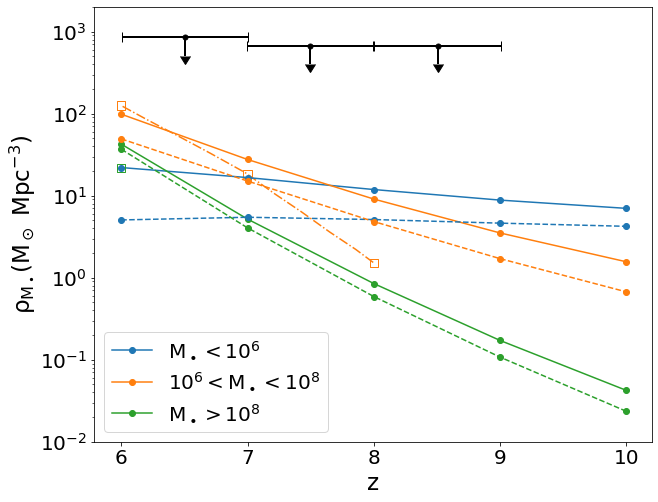

In [11]:
# M range: <6, 6-8, >8
# Ni+ 22 green symbol deleted 

%matplotlib inline
corr = 'U'
zmax = 11
M_up  = 1e7
L_up  = -26
# L_ups = [-23,-24,-25,-26,-27] # 可用集合
ndraw = 3
labels = [r'$\mathrm{t_{life}}$', r'$\log \delta$', r'$\lambda_0$', r'$\alpha$']
z = 6
zs = np.arange(z,zmax,1)

fig, ax = plt.subplots(num='rhoM',figsize=(10, 8))

# Ni 2022 & Treister 2013
# p1, = ax.plot(x_68,y_68,linestyle='-.',c='C1',label='Ni+ 22')
# p2 = ax.scatter(x_8,y_8,marker='s',s=70,edgecolors='C2',facecolors='none',label=' ',zorder=3)
# p3  = ax.scatter(x_T13,y_T13,marker=r'$\downarrow$',s=100,c='k',label='Treister+ 13')

# first_legend = ax.legend([(p1, p2),p3], ['Ni+ 2022','Treister+ 13'], 
#                            numpoints=1,
#                            handler_map={tuple: HandlerTuple(ndivide=1,pad=.5,xpad=0,ypad=.7)},
#                            fontsize=fslegend,loc='upper right')

p1, = ax.plot(np.append(x_68[x_68<=8],8),np.append(y_68[x_68<=8.],pow(10.,linear(x_68,np.log10(y_68),8))),linestyle='-.',c='C1',label='Ni+ 22')
# dots Ni+22
for z in [6,7,8]:
    p2 = ax.scatter(z, pow(10., linear(x_68,np.log10(y_68),z)),marker='s',s=70,edgecolors='C1',
               facecolors='none',label=' ')
#     print(x_68[np.argmax(x_68>=z)],y_68[np.argmax(x_68>=z)])
p2_ = ax.scatter(x_8,y_8,marker='s',s=70,edgecolors='C2',facecolors='none',label=' ',zorder=3)

# p3  = ax.scatter(x_T13,y_T13,marker=r'$\downarrow$',s=150,c='k',label='Treister+ 13')
uplims = np.array([1,1,1], dtype=bool)
p3  = ax.errorbar(x_T13, y_T13,c='k',fmt='o',ms=5,
                 xerr = .5,
                 yerr = .4*y_T13,
                 uplims=uplims,elinewidth=2,capsize=5)


first_legend = ax.legend([(p1,p2_),p3], ['Ni+ 22','Treister+ 13'], 
#                            numpoints=1,
#                            handler_map={tuple: HandlerTuple(ndivide=1,pad=.5,xpad=0,ypad=.7)},
                           handler_map={tuple: HandlerTuple(ndivide=1,xpad=0.1,ypad=-.3)},
                           fontsize=fslegend,loc=(.6,.73))
# 不用这俩legend了
# ax.add_artist(first_legend)


for f_seed in [0.1, 0.01]:
    f_seedlabel = 'f%d'%abs(int(np.log10(f_seed)))
    # readprex = '../4p/M0r8_' + f_seedlabel # on sk1
    readprex = '../M0r8_' + f_seedlabel # local
    fname = readprex + '.h5'
    prex = readprex
    # fname = '../4p/3n2f_logd_4pr8_f2.h5'
    reader = emcee.backends.HDFBackend(fname)
    ndim = len(labels)

    tau = reader.get_autocorr_time(tol=1)
    tau = np.max(tau); print('max tau:',tau)
    Nburnin = int(3*tau)
    Nthin = int(tau/2)

    # Nburnin = 0
    Nthin = 1
    samples = reader.get_chain(discard=Nburnin)
    probs = reader.get_log_prob(discard=Nburnin)
    print('len of samples:', len(samples))

    samples = reader.get_chain(discard=Nburnin, thin=Nthin, flat=True)
    probs = reader.get_log_prob(discard=Nburnin, thin=Nthin, flat=True)
    print('len of extracted samples:', len(samples))
    theta_max = samples[np.argmax(probs)]
    print('best paras:',theta_max,np.max(probs))
    T_stay = T[:-int(f_seed*len(T))]
    
    

    rhoM_min = []; rhoM_max = []
    rhoM = {'<1e6':[],'<1e6_int':[],'1e6<M<1e8':[],'>1e8':[]}
    # xs of models
    Mx = M_BH[::int(N_mf/100)] # ~100 points

    dlog10Mx = np.log10(Mx[1]/Mx[0])
    abin = np.append(np.log10(Mx)-dlog10Mx/2., np.log10(Mx[-1])+dlog10Mx/2.)
    for z in zs:    
        #--- output 3 curves: best, med, std
        T_ = ascii.read(prex+'linBHMFz{:d}'.format(z), guess=False, delimiter=' ')
        Mx, y_best, med, spread = T_['Mx'], T_['y_best'], T_['med'], T_['spread']
        # add seed M_BHs 
        hist_mf, bin_edges = np.histogram(np.log10(T_stay['Mstar0']),bins=abin,density=False)
#         print(hist_mf)
#         y_seed = hist_mf*n_base*f_bsm/len(T)/dlog10Mx,

#         axm.plot(Mx, y_best+hist_mf*n_base*f_bsm/len(T)/dlog10Mx,
#                  color='C%d'%(z%10), label='z=%d'%z)

        y_tot = y_best+hist_mf*n_base*f_bsm/len(T)/dlog10Mx
        #--- mass integration above M_up
        dn_best = y_best*dlog10Mx
        
        index = np.where(Mx<1e6)
        rhoM['<1e6'].append(np.sum(dn_best[index]*Mx[index]) + n_base*f_bsm*np.sum(T_stay['Mstar0'])/len(T) )
#         rhoM['<1e6_int'].append(np.sum(y_tot[index]*Mx[index]*dlog10Mx))
#         index = np.logical_and(Mx>1e5,Mx<1e6)
#         rhoM['1e5<M<1e6'].append(np.sum(dn_best[index]*Mx[index]) )
        index = np.logical_and(Mx>1e6,Mx<1e8)
        rhoM['1e6<M<1e8'].append(np.sum(dn_best[index]*Mx[index]) )
        index = np.where(Mx>1e8)
        rhoM['>1e8'].append(np.sum(dn_best[index]*Mx[index]))

    line1, = ax.plot(zs,rhoM['<1e6'],ls=linestyles[f_seed],marker='o',
            label=r'$\mathrm{M_\bullet<10^6}}$',c='C0')
    line2, = ax.plot(zs,rhoM['1e6<M<1e8'],linestyle=linestyles[f_seed],marker='o',
            label=r'$\mathrm{10^6<M_\bullet<10^8}$',c='C1')
    line3, = ax.plot(zs,rhoM['>1e8'],linestyle=linestyles[f_seed],marker='o',
            label=r'$\mathrm{M_\bullet>10^8}$',c='C2')
    
    if f_seed == 0.1:
        ax.legend(handles=[line1,line2,line3], fontsize=fslegend,loc='lower left')


ax.set_ylim(1e-2,2e3)
ax.set_yscale('log')
ax.set_xlabel('z',fontsize=fslabel)
ax.set_xticks(zs)
ax.set_ylabel(r'$\mathrm{\rho_{M_\bullet} (M_\odot~Mpc^{-3})}$',fontsize=fslabel)
ax.tick_params(labelsize=fstick)
fig.savefig(figpre+'rhoM_comb.pdf',dpi=600,bbox_inches='tight')

In [ ]:
a = np.linspace(1,50)
a,a>2

In [ ]:
a[np.argmax(a<2)]